# 머신러닝기법 데이터분석_이준오

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Reding data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-whitegrid')

In [ ]:
os.getcwd()

In [ ]:
df_train = pd.read_csv('../input/new-york-city-taxi-fare-prediction/train.csv',\
                       nrows = 2_000_000, parse_dates=["pickup_datetime"])

df_train.head()

In [ ]:
#데이터 타입 확인
df_train.dtypes

In [ ]:
df_train.describe() #데이터 요약 통계량 확인

In [ ]:
#결측치 확인
df_train.isnull().sum() 

- fare_amount의 최소값은 음수이므로 삭제
- 경도/위도의 일부가 없으므로 데이터셋에서 삭제
- fare_amount 평균은 11.4 USD, 표준편차는 9.9 USD
- 모델을 만들 때 9.9 USD보다 좋기를 원함

In [ ]:
print('Old size: %d' % len(df_train))
df_train = df_train[df_train.fare_amount>=0]
print('New size: %d' % len(df_train))

In [ ]:
df_train[df_train.fare_amount <100].fare_amount.hist(bins=100,figsize=(14,3))
plt.xlabel('fare $USD')
plt.title('Histogram')
plt.show()

### 결측치 삭제

In [ ]:
print('Old size: %d' % len(df_train))
df_train = df_train.dropna(how = 'any', axis ='rows')
print('New size: %d' % len(df_train))

### Test data

In [ ]:
#test data 로드
df_test = pd.read_csv('../input/new-york-city-taxi-fare-prediction/test.csv')
df_test.head(5)

In [ ]:
df_test.describe()

### 위치 데이터
위치 데이터를 처리 할 때지도에 좌표를 플로팅하고 싶습니다. 이를 통해 데이터를보다 잘 볼 수 있습니다. 이를 위해 다음 웹 사이트를 사용합니다.

사용하기 쉬운지도 및 GPS 도구 : https://www.gps-coordinates.net/

위치 사이의 거리를 계산하십시오 : https://www.travelmath.com/flying-distance/

거리 상자를 사용하여 거리 상자를 열어 지도를 엽니다 : https://www.openstreetmap.org/export#map=8/52.154/5.295

뉴욕시 좌표는 (https://www.travelmath.com/cities/New+York,+NY) 입니다.

- 경도 = -74.0063889
- 위도 = 40.7141667

테스트 세트의 최소 및 최대 좌표를 사용하여 관심있는 경계 상자를 [long_min, long_max, latt_min, latt_max]로 정의합니다. 이런 식으로 테스트 세트의 전체 픽업 / 드롭 오프 좌표 범위에 대한 모델을 학습합니다.

Open Street Map에서 지도에 데이터 포인트를 놓습니다

In [ ]:
# 최소 , 최대 경도 테스트 셋
min(df_test.pickup_longitude.min(), df_test.dropoff_longitude.min()),\
max(df_test.pickup_longitude.max(), df_test.dropoff_longitude.max())

In [ ]:
# 최소 , 최대 위도 테스트 셋
min(df_test.pickup_latitude.min(), df_test.dropoff_latitude.min()),\
max(df_test.pickup_latitude.max(), df_test.dropoff_latitude.max())

In [ ]:
# 아래 테스트 세트와 사용되는 함수
# 뉴욕시에 해당하는 위도 경도 섹터 안에 있는 데이터만 가져올 수 있다.
def select_within_boundingbox(df, BB):
    return (df.pickup_longitude >= BB[0]) & (df.pickup_longitude <= BB[1]) & \
           (df.pickup_latitude >= BB[2]) & (df.pickup_latitude <= BB[3]) & \
           (df.dropoff_longitude >= BB[0]) & (df.dropoff_longitude <= BB[1]) & \
           (df.dropoff_latitude >= BB[2]) & (df.dropoff_latitude <= BB[3])

# 뉴욕시 지도 이미지 로드
BB = (-74.5, -72.8, 40.5, 41.8)
nyc_map = plt.imread('https://aiblog.nl/download/nyc_-74.5_-72.8_40.5_41.8.png')

# 뉴욕시 지도 확대버전 로드
BB_zoom = (-74.3, -73.7, 40.5, 40.9)
nyc_map_zoom = plt.imread('https://aiblog.nl/download/nyc_-74.3_-73.7_40.5_40.9.png')

In [ ]:
print('Old size: %d' % len(df_train))
df_train = df_train[select_within_boundingbox(df_train, BB)]
print('New size: %d' % len(df_train))

In [ ]:
# NYC맵에 데이터를 그리는데 사용되는 함수
# (데이터, 위도경도섹터, 지도이미지, 마커의크기, 투명도 )
# 택시를 태운 위치, 택시에서 내려준 위치
def plot_on_map(df, BB, nyc_map, s=10, alpha=0.2):
    fig, axs = plt.subplots(1, 2, figsize=(16,10))
    axs[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup locations')
    axs[0].imshow(nyc_map, zorder=0, extent=BB)

    axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff locations')
    axs[1].imshow(nyc_map, zorder=0, extent=BB)

In [ ]:
plot_on_map(df_train, BB, nyc_map,s=1,alpha=0.3)

In [ ]:
# 훈련데이터로 확대된 NYC 맵에 점을 찍음
plot_on_map(df_train, BB_zoom, nyc_map_zoom, s=1, alpha=0.3)

In [ ]:
# 테스트데이터로 맵에 점을 찍음
plot_on_map(df_test, BB, nyc_map, alpha=1.0, s=20)

- 훈련데이터에서 일부 위치가 물에 있으므로 노이즈로 간주되어 데이터 셋에서 삭제된다.

(참조) 이 커널에서 배운 데이터를 시각화하는 또 다른 흥미로운 방법은

https://www.kaggle.com/drgilermo/dynamics-of-new-york-city-animation 입니다. 

매우 작은 도트 크기를 사용하면 뉴욕의 실제 거리가 표시됩니다.

In [ ]:
def plot_hires(df, BB, figsize=(12, 12), ax=None, c=('r', 'b')):
    if ax == None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    idx = select_within_boundingbox(df, BB)
    ax.scatter(df[idx].pickup_longitude, df[idx].pickup_latitude, c=c[0], s=0.01, alpha=0.5)
    ax.scatter(df[idx].dropoff_longitude, df[idx].dropoff_latitude, c=c[1], s=0.01, alpha=0.5)

In [ ]:
# 빨간색 : 택시를 태운 위치
# 파란색 : 택시를 내려준 위치

plot_hires(df_train, (-74.1, -73.7, 40.6, 40.9))
plot_hires(df_train, (-74, -73.95, 40.7, 40.8))

### 물에 있는 데이터들을 삭제

- 물에 있는 노이즈 데이터를 제거하기위해 NYC 맵에서 bool 토지/물 맵을 만듭니다. 포토샵을 사용하여 물의 파란색을 제한하고 맵을 정리했습니다. 결과는 아래와 같습니다.

In [ ]:
plt.imread('https://aiblog.nl/download/nyc_mask-74.5_-72.8_40.5_41.8.png')[:,:,0] > 0.9
plt.figure(figsize=(8,8))
plt.imshow(nyc_map, zorder=0)
plt.imshow(nyc_mask, zorder=1, alpha=0.7);# note: True is show in black, False in white.
# 검정 : 물
# 하양 : 육지

- 다음으로 경도 / 위도 좌표를 xy 픽셀 좌표로 변환해야합니다. 
- lonlat_to_xy 함수는이 변환을 구현합니다. 이미지 y 축이 위에서 아래로 향하므로 y 좌표를 반전시켜야합니다.

- 모든 데이터 포인트에 대해 xy 픽셀 좌표가 계산되면 부울 인덱스가 NYC 마스크를 사용하여 계산됩니다.

In [ ]:
# 경도/위도 좌표를 이미지 xy 좌표로 변환
def lonlat_to_xy(longitude, latitude, dx, dy, BB):
    return (dx*(longitude - BB[0])/(BB[1]-BB[0])).astype('int'), \
           (dy - dy*(latitude - BB[2])/(BB[3]-BB[2])).astype('int')

In [ ]:
pickup_x, pickup_y = lonlat_to_xy(df_train.pickup_longitude, df_train.pickup_latitude,\
                                  nyc_mask.shape[1], nyc_mask.shape[0], BB)
dropoff_x, dropoff_y = lonlat_to_xy(df_train.dropoff_longitude, df_train.dropoff_latitude,\
                                    nyc_mask.shape[1], nyc_mask.shape[0], BB)

In [ ]:
# 물에 찍혀있는 점들 갯수
idx = (nyc_mask[pickup_y, pickup_x] & nyc_mask[dropoff_y, dropoff_x])
print("Number of trips in water: {}".format(np.sum(~idx)))

마지막으로 물에서 데이터 포인트를 제거하기 위해 재사용 할 수있는 하나의 함수를 만듭니다

In [ ]:
def remove_datapoints_from_water(df):
    def lonlat_to_xy(longitude, latitude, dx, dy, BB):
        return (dx*(longitude - BB[0])/(BB[1]-BB[0])).astype('int'),\
               (dy - dy*(latitude - BB[2])/(BB[3]-BB[2])).astype('int')

    # nyc 바운딩
    BB = (-74.5, -72.8, 40.5, 41.8)
    
    # read nyc mask and turn into boolean map with
    # 육지 = True, 물 = False
    nyc_mask = plt.imread('https://aiblog.nl/download/nyc_mask-74.5_-72.8_40.5_41.8.png')[:,:,0] > 0.9
    
    # 각 론에 대해 계산하고, 마스크 맵에서 xy 좌표를 위도 좌표로 계산하십시오.
    pickup_x, pickup_y = lonlat_to_xy(df.pickup_longitude, df.pickup_latitude, 
                                      nyc_mask.shape[1], nyc_mask.shape[0], BB)
    dropoff_x, dropoff_y = lonlat_to_xy(df.dropoff_longitude, df.dropoff_latitude, 
                                      nyc_mask.shape[1], nyc_mask.shape[0], BB)    
    # boolean 인덱스 계산
    idx = nyc_mask[pickup_y, pickup_x] & nyc_mask[dropoff_y, dropoff_x]
    
    # 육지에만 있는 데이터포인트 반환
    return df[idx]

In [ ]:
print('Old size: %d' % len(df_train))
df_train = remove_datapoints_from_water(df_train)
print('New size: %d' % len(df_train))

In [ ]:
# 물에 찍힌 점들을 제외한 데이터로 찍어본다.
# plot training data
plot_on_map(df_train, BB, nyc_map)

평방 마일 당 데이터 포인트 밀도

픽업 및 드롭 오프 위치의 산점도는 밀도에 대한 빠른 인상을줍니다. 그러나 밀도를 시각화하기 위해 영역 당 데이터 포인트 수를 계산하는 것이 더 정확합니다. 아래 코드는 평방 마일 당 픽업 및 드롭 오프 데이터 포인트를 계산합니다. 이것은 '핫스팟'에 대한 더 나은 시야를 제공합니다.

In [ ]:
#이 플롯과 추가 분석을 위해서는 경도, 위도 좌표 위치 간의 거리를 마일 단위로 계산하는 함수가 필요합니다.
# This function is based on https://stackoverflow.com/questions/27928/
# calculate-distance-between-two-latitude-longitude-points-haversine-formula 
# 마일 단위의 거리를 반환하는 함수
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a)) # 2*R*asin...

# 먼저 평방 마일 당 데이터 포인트 밀도로 두 개의 배열을 계산하십시오.
n_lon, n_lat = 200, 200 # 경도, 위도 차원 당 그리드 bins 수
density_pickup, density_dropoff = np.zeros((n_lat, n_lon)), np.zeros((n_lat, n_lon)) # prepare arrays

# 격자 영역의 데이터 포인트 수를 계산하기 위해 numpy.digitize () 함수가 사용됩니다.
# 이 함수는 데이터 포인트 수를 계산하기 위해 (위치) 빈이있는 배열이 필요합니다
# per bin.
bins_lon = np.zeros(n_lon+1) # bin
bins_lat = np.zeros(n_lat+1) # bin
delta_lon = (BB[1]-BB[0]) / n_lon # bin longutide width
delta_lat = (BB[3]-BB[2]) / n_lat # bin latitude height
bin_width_miles = distance(BB[2], BB[1], BB[2], BB[0]) / n_lon # bin width in miles
bin_height_miles = distance(BB[3], BB[0], BB[2], BB[0]) / n_lat # bin height in miles
for i in range(n_lon+1):
    bins_lon[i] = BB[0] + i * delta_lon
for j in range(n_lat+1):
    bins_lat[j] = BB[2] + j * delta_lat
    
# 경도, 위도 치수 당 디지털화
inds_pickup_lon = np.digitize(df_train.pickup_longitude, bins_lon)
inds_pickup_lat = np.digitize(df_train.pickup_latitude, bins_lat)
inds_dropoff_lon = np.digitize(df_train.dropoff_longitude, bins_lon)
inds_dropoff_lat = np.digitize(df_train.dropoff_latitude, bins_lat)

# Count per grid bin
# note: as the density_pickup will be displayed as image, the first index is the y-direction, 
#       the second index is the x-direction. Also, the y-direction needs to be reversed for
#       properly displaying (therefore the (n_lat-j) term)
#밀도 _ 픽업이 이미지로 표시되므로 첫 번째 인덱스는 y 방향입니다.
#두 번째 인덱스는 x 방향입니다. 또한 y 방향을 반대로 바꾸어야합니다.
#올바르게 표시 (따라서 (n_lat-j) 항)
dxdy = bin_width_miles * bin_height_miles
for i in range(n_lon):
    for j in range(n_lat):
        density_pickup[j, i] = np.sum((inds_pickup_lon==i+1) & (inds_pickup_lat==(n_lat-j))) / dxdy
        density_dropoff[j, i] = np.sum((inds_dropoff_lon==i+1) & (inds_dropoff_lat==(n_lat-j))) / dxdy

In [ ]:
# 밀도 배열 플롯
fig, axs = plt.subplots(2, 1, figsize=(18, 24))
axs[0].imshow(nyc_map, zorder=0, extent=BB);
im = axs[0].imshow(np.log1p(density_pickup), zorder=1, extent=BB, alpha=0.6, cmap='plasma')
axs[0].set_title('Pickup density [datapoints per sq mile]')
cbar = fig.colorbar(im, ax=axs[0])
cbar.set_label('log(1 + #datapoints per sq mile)', rotation=270)

axs[1].imshow(nyc_map, zorder=0, extent=BB);
im = axs[1].imshow(np.log1p(density_dropoff), zorder=1, extent=BB, alpha=0.6, cmap='plasma')
axs[1].set_title('Dropoff density [datapoints per sq mile]')
cbar = fig.colorbar(im, ax=axs[1])
cbar.set_label('log(1 + #datapoints per sq mile)', rotation=270)

이 도표는 데이터 포인트가 Manhatten과 3 개의 공항 (JFK, EWS, LGR)에 집중되어 있음을 분명히 보여줍니다. Seymour 근처 (오른쪽 위) 핫스팟도 있습니다.

## pickup할 때 교통 밀도

위의 밀도 플롯은 시간과 연도별로 트래픽 밀도를 시각화 할 수 있는지 확인했습니다. 한 지역의 픽업 수를 세면 교통 밀도에 대한 인상을 얻을 수 있습니다. 트래픽이 많을수록 드라이브를 만드는 데 시간이 더 걸릴 수 있습니다

In [ ]:
# add time information
df_train['year'] = df_train.pickup_datetime.apply(lambda t: t.year)
df_train['weekday'] = df_train.pickup_datetime.apply(lambda t: t.weekday())
df_train['hour'] = df_train.pickup_datetime.apply(lambda t: t.hour)

In [ ]:
# some constants needed to calculate pickup traffic density
# 픽업 트래픽 밀도를 계산하는 데 필요한 일부 상수
n_hours = 24
n_weekdays = 7
n_years = 7
n_bins_lon = 30
n_bins_lat = 30

# focus on traffic in Manhattan
BB_traffic = (-74.025, -73.925, 40.7, 40.8)

# define function to calculate pickup traffic density
# 픽업 트래픽 밀도를 계산하는 기능 정의
def calculate_trafic_density(df):
    traffic = np.zeros((n_years, n_weekdays, n_hours, n_bins_lat, n_bins_lon))
    
    # To calculate the number of datapoints in a grid area, the numpy.digitize() function is used. 
    # 격자 영역의 데이터 포인트 수를 계산하기 위해 numpy.digitize () 함수가 사용됩니다.
    # This function needs an array with the (location) bins for counting the number of datapoints
    # 이 함수는 데이터 포인트 수를 계산하기 위해 (위치) 빈이있는 배열이 필요합니다
    # per bin.
    bins_lon = np.zeros(n_bins_lon+1) # bin
    bins_lat = np.zeros(n_bins_lat+1) # bin
    
    delta_lon = (BB_traffic[1]-BB_traffic[0]) / n_bins_lon # bin longutide width
    delta_lat = (BB_traffic[3]-BB_traffic[2]) / n_bins_lat # bin latitude height
    
    for i in range(n_bins_lon+1):
        bins_lon[i] = BB_traffic[0] + i * delta_lon
    for j in range(n_bins_lat+1):
        bins_lat[j] = BB_traffic[2] + j * delta_lat
    
    # Count per grid bin
    # note: as the density_pickup will be displayed as image, the first index is the y-direction, 
    #       the second index is the x-direction. Also, the y-direction needs to be reversed for
    #       properly displaying (therefore the (n_lat-j) term)
    for y in range(n_years):
        for d in range(n_weekdays):
            for h in range(n_hours):
                idx = (df.year==(2009+y)) & (df.weekday==d) & (df.hour==h)

                # Digitize per longitude, latitude dimension
                inds_pickup_lon = np.digitize(df[idx].pickup_longitude, bins_lon)
                inds_pickup_lat = np.digitize(df[idx].pickup_latitude, bins_lat)

                for i in range(n_bins_lon):
                    for j in range(n_bins_lat):
                        traffic[y, d, h, j, i] = traffic[y, d, h, j, i] + \
                                                 np.sum((inds_pickup_lon==i+1) & (inds_pickup_lat==j+1))
    
    return traffic 

# define function to plot pickup traffic density
# 픽업 트래픽 밀도를 플롯하는 기능 정의
def plot_traffic(traffic, y, d):
    days = {'monday' : 0, 'tuesday' : 1, 'wednesday' : 2, 'thursday' : 3, 'friday' : 4, 'saturday' : 5, 'sunday' : 6}
    fig, axs = plt.subplots(3,8,figsize=(18,7))
    axs = axs.ravel()
    for h in range(24):
        axs[h].imshow(traffic[y-2009,days[d],h,::-1,:], zorder=1, cmap='coolwarm', clim=(0, traffic.max()))
        axs[h].get_xaxis().set_visible(False)
        axs[h].get_yaxis().set_visible(False)
        axs[h].set_title('h={}'.format(h))
    fig.suptitle("Pickup traffic density, year={}, day={} (max_pickups={})".format(y, d, traffic.max()))

In [ ]:
traffic = calculate_trafic_density(df_train)

이제 밀도를 계산하고 플롯을 시각화 해 봅시다.

참고 : 플롯의 품질은 사용 된 데이터 포인트 수에 따라 다릅니다. 이 노트북은 기본적으로 500k 포인트를 사용하는데, 이는 양호한 트래픽 밀도 플롯에는 충분하지 않습니다. 포인트 수를 늘리면 더 나은 플롯을 얻을 수 있습니다.

- 시간대별 트래픽 밀도

In [ ]:
plot_traffic(traffic, 2009, 'monday')
plot_traffic(traffic, 2009, 'friday')
plot_traffic(traffic, 2009, 'sunday')

이 그림에서 이미 시간별, 위치별로 다양한 트래픽 밀도 패턴을 볼 수 있습니다. 

예 : 일요일 h = 0-3 시간 (토요일 밤에서 일요일까지)에는 평일보다 더 많은 트래픽이 있습니다. 나는 이것이 주말에 외출을 즐기는 사람들로부터 온 것으로 추정합니다. 다른 해를 시각화 해 봅시다

In [ ]:
plot_traffic(traffic, 2014, 'monday')
plot_traffic(traffic, 2014, 'friday')
plot_traffic(traffic, 2014, 'sunday')

## 거리 및 시간 시각화
모델을 만들기 전에 몇가지 기본 가정을 세운다.

- 픽업과 하차장소 사이의 거리가 멀수록 요금이 더 높다.
- 공항을 오가는 일부 여행은 고정요금이다.
- 야간 요금은 낮시간과 다르다.


### 픽업과 하차장소 사이의 거리가 멀수록 요금이 더 높다.
거리-운임 관계를 시각화하려면 먼저 여행 거리를 계산해야합니다.

In [ ]:
# 새 컬럼으로 거리가 몇 마일인지 데이터프레임에 추가한다.
df_train['distance_miles'] = distance(df_train.pickup_latitude, df_train.pickup_longitude, \
                                      df_train.dropoff_latitude, df_train.dropoff_longitude)

df_train.distance_miles.hist(bins=50, figsize=(12,4))
plt.xlabel('distance miles')
plt.title('Histogram ride distances in miles')
df_train.distance_miles.describe()

대부분은 짧은 마일의 이용이고
small peak ~13마일내의 값은 공항드라이브 때문일 수 있다.

passenger_count의 영향도 살펴본다.


In [ ]:
df_train.groupby('passenger_count')['distance_miles', 'fare_amount'].mean()

passenger_count가 0인 것은 이상함(택시로 물건을 운송하거나, 행정적 오류가 있을 수 있다.)

'fare per mile'을 사용하여 fare_amount를 찾는 대신 인사이트를 제공합니다.


In [ ]:
print("Average $USD/Mile : {:0.2f}".format(df_train.fare_amount.sum()\
                                           /df_train.distance_miles.sum()))

In [ ]:
# scatter plot 거리 - 요금
fig, axs = plt.subplots(1, 2, figsize=(16,6))
axs[0].scatter(df_train.distance_miles, df_train.fare_amount, alpha=0.2)
axs[0].set_xlabel('distance mile')
axs[0].set_ylabel('fare $USD')
axs[0].set_title('All data')

# 데이터의 일부를 확대
idx = (df_train.distance_miles < 15) & (df_train.fare_amount < 100)
axs[1].scatter(df_train[idx].distance_miles, df_train[idx].fare_amount, alpha=0.2)
axs[1].set_xlabel('distance mile')
axs[1].set_ylabel('fare $USD')
axs[1].set_title('Zoom in on distance < 15 mile, fare < $100');


여기서 알 수 있는 것들

- 거리는 0이지만 요금이 0이 아닌 여행이 있습니다. 이것이 같은 위치를 오가는 것일 수 있습니까? 데이터 세트에 충분한 정보가 없기 때문에 이러한 요금을 예측하는 것은 어려울 것입니다.
- 여행 거리가 50 마일 이상이지만 요금이 저렴한 여행이 있습니다. 아마도 이것들은 할인 여행입니까? 또는 앞서 언급 한 시모어 근처의 핫스팟 (위의 밀도 도표 참조)?
- 오른쪽 그림의 수평선은 JFK 공항을 오가는 고정 요금 여행을 다시 나타낼 수 있습니다.
- 전반적으로 +/- 100/20 = 5 $ USD / mile의 평균 요금으로 거리와 요금 사이에 (선형) 관계가있는 것 같습니다.

마지막 요점을 고려할 때 NYC 택시 요금 가격을 Google에 검색하면 다음을 발견합니다.

- 3km 여행의 경우 $ 4.00 – $ 10.00 (https://www.priceoftravel.com/555/world-taxi-prices-what-a-3-kilometer-ride-costs-in-72-big-cities/)
- 시작 범위 : $ 2.50-$ 3.30, 1km 범위 : $ 1.55-$ 2.98 (https://www.numbeo.com/taxi-fare/in/New-York)
- 택시 가격에 대한 자세한 설명 :       http://home.nyc.gov/html/tlc/html/passenger/taxicab_rate.shtml
- JFK 및 기타 공항을 제외한 대부분의 타기의 초기 요금은 입장시 $ 2.50입니다. 그 후 단위가 1 마일의 1/5 마일로 정의되거나 택시가 시간당 12 마일 이상을 여행 할 때마다 0.5 달러가 있습니다 ... 우리는 자동차의 속도를 해독 할 수 없으므로 1 / 5 마일을 단위로하여 거리를이 단위로 변환합니다.
- 오후 8시-오전 6시 사이에 추가 요금 $ 0.5
- 월요일부터 금요일까지 오후 4시에서 오후 8시 사이에 피크 시간 주중 추가 요금이 $ 1입니다.
- 뉴욕시 또는 나소, 서퍽, 웨스트 체스터, 록 랜드, 더치스, 오렌지 또는 퍼트 남 카운티에서 끝나는 여행에 대해 $ 0.5 MTA 주정부 할증료가 있습니다.
- $ 0.3 개선 할증료가 있습니다


참고 : 데이터 세트에서 계산 된 거리는 지점 간입니다. 실제로 도로로 측정 한 거리가 더 큽니다.

In [ ]:
# 거리가 0.05마일보다 작은 데이터는 삭제
idx = (df_train.distance_miles >= 0.05)
print('Old size: %d' % len(df_train))
df_train = df_train[idx]
print('New size: %d' % len(df_train))

공항을 오가는 일부 여행은 고정 요금입니다.

이 데이터를 탐색하는 또 다른 방법은 잘 알려진 장소를 오가는 여행을 확인하는 것입니다.
- 예 : JFK 공항 여행. 거리에 따라 공항 여행은 종종 고정 가격입니다.

In [ ]:
# JFK airport coordinates, see https://www.travelmath.com/airport/JFK
jfk = (-73.7822222222, 40.6441666667)
nyc = (-74.0063889, 40.7141667)

def plot_location_fare(loc, name, range=1.5):
    # select all datapoints with dropoff location within range of airport
    # 공항 범위 내에서 하차 위치가있는 모든 데이터 포인트를 선택하십시오.
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    idx = (distance(df_train.pickup_latitude, df_train.pickup_longitude, loc[1], loc[0]) < range)
    df_train[idx].fare_amount.hist(bins=100, ax=axs[0])
    axs[0].set_xlabel('fare $USD')
    axs[0].set_title('Histogram pickup location within {} miles of {}'.format(range, name))

    idx = (distance(df_train.dropoff_latitude, df_train.dropoff_longitude, loc[1], loc[0]) < range)
    df_train[idx].fare_amount.hist(bins=100, ax=axs[1])
    axs[1].set_xlabel('fare $USD')
    axs[1].set_title('Histogram dropoff location within {} miles of {}'.format(range, name));
    
plot_location_fare(jfk, 'JFK Airport')

공항을 오가는 고정 가격이있는 것 같습니다. 또한 누군가가 너무 많이 지불했을 수도 있습니다 ($ 250 ??)!

다른 두 공항에서도 똑같이하겠습니다.

In [ ]:
ewr = (-74.175, 40.69) # Newark Liberty International Airport, see https://www.travelmath.com/airport/EWR
lgr = (-73.87, 40.77) # LaGuardia Airport, see https://www.travelmath.com/airport/LGA
plot_location_fare(ewr, 'Newark Airport')
plot_location_fare(lgr, 'LaGuardia Airport')

## 야간요금은 낮시간과 다릅니다.
시간과 fare/km의 관계를 시각화 하기 위해 연도, 시간, KM당 요금/$USD의 3개 열이 데이터에 추가됩니다.

In [ ]:
df_train['fare_per_mile'] = df_train.fare_amount / df_train.distance_miles
df_train.fare_per_mile.describe()

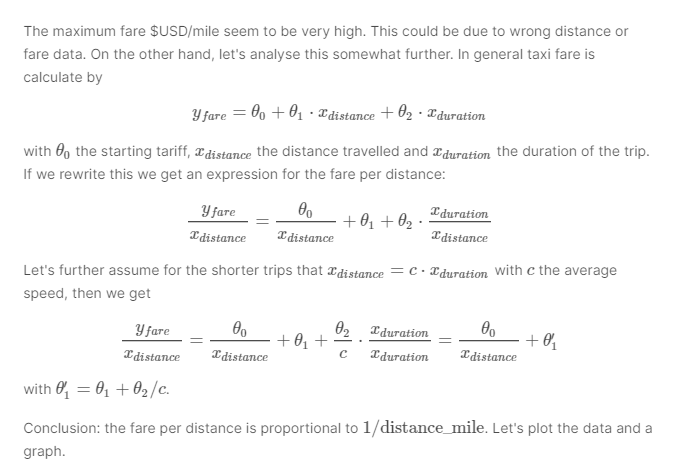

In [ ]:
idx = (df_train.distance_miles < 3) & (df_train.fare_amount < 100)
plt.scatter(df_train[idx].distance_miles, df_train[idx].fare_per_mile)
plt.xlabel('distance mile')
plt.ylabel('fare per distance mile')

# theta here is estimated by hand
theta = (16, 4.0)
x = np.linspace(0.1, 3, 50)
plt.plot(x, theta[0]/x + theta[1], '--', c='r', lw=2);

거리 당 요금은 더 큰 거리보다 작은 거리 (<0.5 마일)에 대해 더 많이 퍼져 있습니다. 이것은 다음과 같이 설명 될 수 있습니다 : 우리는 도로가 아닌 지점 간 거리를 측정합니다. 더 작은 거리의 경우이 두 측정 방법의 차이가 더 클 것으로 예상됩니다. 이것은 선형 모델에 비해 고급 모델 (딥 러닝 NN)이 향상 될 것이라고 생각하는 한 가지 측면입니다.

[30/07/2018] 더 작은 거리에 대한 확산이 더 큰 다른 이유는 출퇴근 시간에 트래픽이 느리기 때문일 수 있습니다. 출퇴근 시간에 짧은 드라이브는 기간이 더 다양합니다.

거리 당 요금 대 요금 분석을 계속합시다. 다음으로 팬더 피벗 테이블을 사용하여 요약을 계산하고 플롯합니다.

In [ ]:
# display pivot table
df_train.pivot_table('fare_per_mile', index='hour', columns='year').plot(figsize=(14,6))
plt.ylabel('Fare $USD / mile');


$ USD / 마일 요금은 수년과 시간에 따라 다르다는 것을 분명히 알 수 있습니다.

이것을 더 조사하기 위해 Google지도를 사용하여 두 여행의 예상 지속 시간을 계산했습니다.

- 여행 1 : 뉴욕시 박물관에서 비콘 극장까지 4.5km, Manhatten을 떠나지 않음
- 여행 2 : Times Squared에서 Maria Hermandez Park까지 12km, Queens Midtown Tunnel (유료 도로)


아래는 데이터 및 그래프입니다. 같은 유형의 그래프가 보입니다. 따라서 교통량에 따라 여행 기간과 요금이 결정됩니다. 트래픽 양은 하루 중 시간에 따라 다릅니다.

In [ ]:
hours = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, \
         13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

# minimum & maximum duration in minutes
trip1_min = [10, 10, 10, 10, 10, 10, 10, 12, 14, 14, 14, 14, \
             14, 14, 14, 14, 14, 12, 12, 12, 12, 12, 10, 10]
trip1_max = [20, 18, 16, 16, 16, 18, 22, 26, 40, 35, 35, 35, \
             35, 35, 35, 40, 35, 30, 28, 28, 26, 26, 24, 24]

trip2_min = [18, 18, 18, 18, 18, 18, 20, 24, 28, 30, 30, 30, \
             28, 28, 26, 28, 30, 28, 26, 22, 22, 22, 20, 20]
trip2_max = [35, 35, 30, 28, 28, 30, 40, 55, 75, 75, 70, 70, \
             60, 60, 60, 60, 60, 65, 55, 45, 45, 50, 45, 40]

plt.figure(figsize=(12, 5))
plt.plot(hours, trip1_min, '--', c='b', label="trip1 (2.7 mile) - minimum duration") #최소기간
plt.plot(hours, trip1_max, '-', c='b', label="trip1 (2.7 mile) - maximum duration") #최대기간
plt.plot(hours, trip2_min, '--', c='r', label="trip2 (7.2 mile) - minimum duration")
plt.plot(hours, trip2_max, '-', c='r', label="trip2 (7.2 mile) - maximum duration")
plt.xlabel('hour of the day')
plt.ylabel('driving time (min)')
plt.title('Estimated driving time for two trips using Google Map traffic info')
plt.legend();

요금 / 시간 의존성에 대한보다 심층적 인 분석이 아래에 설명되어 있습니다.

여기서는 연간 및 시간당 요금을 계산하고 선형 회귀를 수행합니다. 줄거리를 조사 할 때 수년에 걸쳐 가격이 상승하는 것을 분명히 알 수 있습니다.

In [ ]:
from sklearn.linear_model import LinearRegression

# plot all years
for year in df_train.year.unique():
    # create figure
    fig, axs = plt.subplots(4, 6, figsize=(18, 10))
    axs = axs.ravel()
    
    # plot for all hours
    for h in range(24):
        idx = (df_train.distance_miles < 15) & (df_train.fare_amount < 100) & (df_train.hour == h) & \
              (df_train.year == year)
        axs[h].scatter(df_train[idx].distance_miles, df_train[idx].fare_amount, alpha=0.2, s=1)
        axs[h].set_xlabel('distance miles')
        axs[h].set_ylabel('fare $USD')
        axs[h].set_xlim((0, 15))
        axs[h].set_ylim((0, 70))

        model = LinearRegression(fit_intercept=False)
        x, y = df_train[idx].distance_miles.values.reshape(-1,1), df_train[idx].fare_amount.values.reshape(-1,1)
        X = np.concatenate((np.ones(x.shape), x), axis=1)
        model.fit(X, y)
        xx = np.linspace(0.1, 25, 100)
        axs[h].plot(xx, model.coef_[0][0] + xx * model.coef_[0][1], '--', c='r', lw=2)
        axs[h].set_title('hour = {}, theta=({:0.2f},{:0.2f})'.format(h, model.coef_[0][0], model.coef_[0][1]))

    plt.suptitle("Year = {}".format(year))
    plt.tight_layout(rect=[0, 0, 1, 0.95]);


## 픽업 장소에 따라 요금이 다릅니다.
km 당 요금이 뉴욕 중심까지의 거리가 계산되는 위치에 따라 다른지 여부를 시각화합니다.

NYC 센터까지의 거리 대 여행 거리 대 요금 금액을 플로팅하면이 복잡한 관계에 대한 통찰력이 제공됩니다.

In [ ]:
# add new column to dataframe with distance in mile
df_train['distance_to_center'] = distance(nyc[1], nyc[0], df_train.pickup_latitude, df_train.pickup_longitude)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16,6))
im = axs[0].scatter(df_train.distance_to_center, df_train.distance_miles, c=np.clip(df_train.fare_amount, 0, 100), 
                     cmap='viridis', alpha=1.0, s=1)
axs[0].set_xlabel('pickup distance from NYC center')
axs[0].set_ylabel('distance miles')
axs[0].set_title('All data')
cbar = fig.colorbar(im, ax=axs[0])
cbar.ax.set_ylabel('fare_amount', rotation=270)

idx = (df_train.distance_to_center < 15) & (df_train.distance_miles < 35)
im = axs[1].scatter(df_train[idx].distance_to_center, df_train[idx].distance_miles, 
                     c=np.clip(df_train[idx].fare_amount, 0, 100), cmap='viridis', alpha=1.0, s=1)
axs[1].set_xlabel('pickup distance from NYC center')
axs[1].set_ylabel('distance miles')
axs[1].set_title('Zoom in')
cbar = fig.colorbar(im, ax=axs[1])
cbar.ax.set_ylabel('fare_amount', rotation=270);

'녹색'도트가 많이 있는데, NYC 중심에서 13 마일 거리에있는 약 $ 50에서 $ 60의 요금입니다. JFK 공항을 오가는 여행 때문일 수 있습니다. 우리가 남은 것을보기 위해 그것들을 제거합시다.

In [ ]:
df_train['pickup_distance_to_jfk'] = distance(jfk[1], jfk[0], df_train.pickup_latitude, df_train.pickup_longitude)
df_train['dropoff_distance_to_jfk'] = distance(jfk[1], jfk[0], df_train.dropoff_latitude, df_train.dropoff_longitude)

In [ ]:
# jfk 여행에 대한 것 제거
idx = ~((df_train.pickup_distance_to_jfk < 1) | (df_train.dropoff_distance_to_jfk < 1))

fig, axs = plt.subplots(1, 2, figsize=(16,6))
im = axs[0].scatter(df_train[idx].distance_to_center, df_train[idx].distance_miles, 
                    c=np.clip(df_train[idx].fare_amount, 0, 100), 
                     cmap='viridis', alpha=1.0, s=1)
axs[0].set_xlabel('pickup distance from NYC center')
axs[0].set_ylabel('distance miles')
axs[0].set_title('All data')
cbar = fig.colorbar(im, ax=axs[0])
cbar.ax.set_ylabel('fare_amount', rotation=270)

idx1 = idx & (df_train.distance_to_center < 15) & (df_train.distance_miles < 35)
im = axs[1].scatter(df_train[idx1].distance_to_center, df_train[idx1].distance_miles, 
                     c=np.clip(df_train[idx1].fare_amount, 0, 100), cmap='viridis', alpha=1.0, s=1)
axs[1].set_xlabel('pickup distance from NYC center')
axs[1].set_ylabel('distance miles')
axs[1].set_title('Zoom in')
cbar = fig.colorbar(im, ax=axs[1])
cbar.ax.set_ylabel('fare_amount', rotation=270);

이제 '노란색'도트 (요금 금액> $ 80)가 남아 있습니다. 이러한 데이터 포인트를 이해하기 위해 맵에 플롯합니다.

In [ ]:
idx = (df_train.fare_amount>80) & (df_train.distance_miles<35) 
plot_on_map(df_train[idx], BB, nyc_map)

드롭 오프 (-74.2, 40.65) 근처에 데이터 포인트가 집중되어있는 것 같습니다. Google지도에서이 좌표를 찾은 후 NYC에 두 번째 공항 인 Newark Liberty International Airport가 있다는 것을 알게되었습니다. NYC 센터에서 공항을 왕복하는 요금은 약 80 ~ 100 USD입니다.

내가 찾은 결과가 올바른지 확인하기 위해이 데이터 포인트도 제거하겠습니다. 세 번째 공항 인 LaGuardia Airport도 있으므로 제거합니다.

In [ ]:
df_train['pickup_distance_to_ewr'] = distance(ewr[1], ewr[0], df_train.pickup_latitude, df_train.pickup_longitude)
df_train['dropoff_distance_to_ewr'] = distance(ewr[1], ewr[0], df_train.dropoff_latitude, df_train.dropoff_longitude)
df_train['pickup_distance_to_lgr'] = distance(lgr[1], lgr[0], df_train.pickup_latitude, df_train.pickup_longitude)
df_train['dropoff_distance_to_lgr'] = distance(lgr[1], lgr[0], df_train.dropoff_latitude, df_train.dropoff_longitude)

In [ ]:
# remove all to/from airport trips
idx = ~((df_train.pickup_distance_to_jfk < 1) | (df_train.dropoff_distance_to_jfk < 1) |
        (df_train.pickup_distance_to_ewr < 1) | (df_train.dropoff_distance_to_ewr < 1) |
        (df_train.pickup_distance_to_lgr < 1) | (df_train.dropoff_distance_to_lgr < 1))

fig, axs = plt.subplots(1, 2, figsize=(16,6))
im = axs[0].scatter(df_train[idx].distance_to_center, df_train[idx].distance_miles, 
                    c=np.clip(df_train[idx].fare_amount, 0, 100), 
                     cmap='viridis', alpha=1.0, s=1)
axs[0].set_xlabel('pickup distance from NYC center')
axs[0].set_ylabel('distance miles')
axs[0].set_title('All data')
cbar = fig.colorbar(im, ax=axs[0])
cbar.ax.set_ylabel('fare_amount', rotation=270)

idx1 = idx & (df_train.distance_to_center < 15) & (df_train.distance_miles < 35)
im = axs[1].scatter(df_train[idx1].distance_to_center, df_train[idx1].distance_miles, 
                     c=np.clip(df_train[idx1].fare_amount, 0, 100), cmap='viridis', alpha=1.0, s=1)
axs[1].set_xlabel('pickup distance from NYC center')
axs[1].set_ylabel('distance miles')
axs[1].set_title('Zoom in')
cbar = fig.colorbar(im, ax=axs[1])
cbar.ax.set_ylabel('fare_amount', rotation=270);

공항 출발 / 도착 항공편을 제거하면 데이터에 대한 '선형 적'관점을 제공하는 것으로 보입니다. 운임은 이동 한 거리에 따라 다르며 시작 위치에 크게 좌우되지 않습니다.

## 운임요금 방향의 관련성
지금까지 나는 주로 여행의 총 거리를 요금 금액을 예측하는 주요 특징으로 생각했습니다. 그러나 여행 방향은 어떻습니까? 이것을 시각화하기 위해 델타 경도와 위도 및 운임 금액의 간단한 플롯으로 시작합니다.

In [ ]:
df_train['delta_lon'] = df_train.pickup_longitude - df_train.dropoff_longitude
df_train['delta_lat'] = df_train.pickup_latitude - df_train.dropoff_latitude

# Select trips in Manhattan
BB_manhattan = (-74.025, -73.925, 40.7, 40.8)
idx_manhattan = select_within_boundingbox(df_train, BB_manhattan)

plt.figure(figsize=(14,8))
plt.scatter(df_train[idx_manhattan].delta_lon, df_train[idx_manhattan].delta_lat, s=0.5, alpha=1.0, 
            c=np.log1p(df_train[idx_manhattan].fare_amount), cmap='magma')
plt.colorbar()
plt.xlabel('pickup_longitude - dropoff_longitude')
plt.ylabel('pickup_latitude - dropoff_latidue')
plt.title('log1p(fare_amount)');

이 줄거리에서 볼 수 있듯이 여행 방향은 중요합니다! 따라서 정확한 방향 (도)을 계산하고 방향 대 요금 금액을 플로팅합니다.

In [ ]:
# direction of a trip, from 180 to -180 degrees. Horizontal axes = 0 degrees.
# 180도에서 -180도 사이의 이동 방향. 가로축 = 0도
def calculate_direction(d_lon, d_lat):
    result = np.zeros(len(d_lon))
    l = np.sqrt(d_lon**2 + d_lat**2)
    result[d_lon>0] = (180/np.pi)*np.arcsin(d_lat[d_lon>0]/l[d_lon>0])
    idx = (d_lon<0) & (d_lat>0)
    result[idx] = 180 - (180/np.pi)*np.arcsin(d_lat[idx]/l[idx])
    idx = (d_lon<0) & (d_lat<0)
    result[idx] = -180 - (180/np.pi)*np.arcsin(d_lat[idx]/l[idx])
    return result

df_train['direction'] = calculate_direction(df_train.delta_lon, df_train.delta_lat)

# plot histogram of directions
# 방향의 히스토그램 플롯
plt.figure(figsize=(10,6))
df_train[idx_manhattan].direction.hist(bins=180)
plt.xlabel('direction (degrees)')
plt.title('Histogram direction (Manhattan)')

# 플롯 방향 대 평균 요금 금액
fig, ax = plt.subplots(1, 1, figsize=(14,6))
direc = pd.cut(df_train[idx_manhattan]['direction'], np.linspace(-180, 180, 37))
df_train[idx_manhattan].pivot_table('fare_amount', index=[direc], columns='year', aggfunc='mean').plot(ax=ax)
plt.xlabel('direction (degrees)')
plt.xticks(range(36), np.arange(-170, 190, 10))
plt.ylabel('average fare amount $USD');

이제 맨해튼의 평균 운임 금액은 방향에 따라 다릅니다. 맨해튼의 거리가 수평선과 약 60 도의 각도를 가지기 때문에 이것은 놀라운 일이 아닙니다. 60도 방향에서 Manhatten은 이와 직교하는 방향 (-30도)보다 깁니다. 운임 방향에 대한 방향의 영향을 더 조사하려면 일정 길이의 여행을 고려해야합니다. 아래를 참조하십시오.

In [ ]:
# select trips in Manhattan with +/- 2 miles distance drive
# +/- 2 마일 거리 운전으로 맨해튼에서 일부 여행 선택
idx2 = idx_manhattan & (df_train.distance_miles>1.5) & (df_train.distance_miles<1.7)

# plot direction vs average fare amount
# 플롯 방향 대 평균 요금 금액
fig, ax = plt.subplots(1, 1, figsize=(14,6))
direc = pd.cut(df_train[idx2]['direction'], np.linspace(-180, 180, 37))
df_train[idx2].pivot_table('fare_amount', index=[direc], columns='year', aggfunc='mean').plot(ax=ax)
plt.xlabel('direction (degrees)')
plt.xticks(range(36), np.arange(-170, 190, 10))
plt.ylabel('average fare amount $USD');

따라서 같은 길이의 여행에서도 운임 금액에 대한 방향의 영향을 알 수 있습니다. Oliver 노트북 (https://www.kaggle.com/ojones3/feature-engineering-corrected-manhattan-distance) 은 유클리드 대 맨하탄 거리 측정을 사용하여 여행 거리를 계산하는 차이를 설명합니다. 이 노트에서 계산 된 거리는 지점 간 거리입니다. 이것은 여행의 실제 거리가 아닙니다. 맨해튼 거리를 사용하면 거리가 세로 및 가로 축에 정렬 된 경우 더 나은 근사치를 얻을 수 있습니다.

즉, 우리가 거리를 60도 돌리면 이것이 이 각도에서의 거리가 실제 거리이기 때문에 방향 = 60 또는 -120의 평균 운임이 가장 낮은 이유입니다 (회전하지 않고 거리를 주행). 방향이 60도 또는 -120 도와 다른 경우, 이는 실제로 여행 거리가 더 길어 지므로 운임이 더 높다는 것을 의미합니다.

Kaggle 기본 모델 및 제출 생성
테스트 세트를 탐색하십시오 (예 : 데이터에 동일한 속성이 있는지 확인하십시오.

In [ ]:
# add new column to dataframe with distance in km
# 거리가 킬로미터 인 데이터 프레임에 새 열 추가
df_test['distance_miles'] = distance(df_test.pickup_latitude, df_test.pickup_longitude, \
                                     df_test.dropoff_latitude, df_test.dropoff_longitude)
df_test['distance_to_center'] = distance(nyc[1], nyc[0], \
                                          df_test.dropoff_latitude, df_test.dropoff_longitude)
df_test['hour'] = df_test.pickup_datetime.apply(lambda t: pd.to_datetime(t).hour)
df_test['year'] = df_test.pickup_datetime.apply(lambda t: pd.to_datetime(t).year)

## 모델
위의 분석을 바탕으로 모델을 시작합니다.

fare ~ year,hour,distance,passenger_count

기본 모델의 경우 선형 회귀 모델을 사용합니다.


In [ ]:
# 데이터셋의 정의
# select points 15 miles near NYC center and remove zero passenger datapoints
# NYC 센터 근처에서 15 마일 지점을 선택하고 승객 데이터 포인트중 0인것 제거
idx = (df_train.distance_to_center<15) & (df_train.passenger_count!=0)
features = ['year', 'hour', 'distance_miles', 'passenger_count']
X = df_train[idx][features].values
y = df_train[idx]['fare_amount'].values

In [ ]:
X.shape, y.shape

In [ ]:
# define some handy analysis support function
# 편리한 분석 지원 기능을 정의
from sklearn.metrics import mean_squared_error, explained_variance_score

def plot_prediction_analysis(y, y_pred, figsize=(10,4), title=''):
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    axs[0].scatter(y, y_pred)
    mn = min(np.min(y), np.min(y_pred))
    mx = max(np.max(y), np.max(y_pred))
    axs[0].plot([mn, mx], [mn, mx], c='red')
    axs[0].set_xlabel('$y$')
    axs[0].set_ylabel('$\hat{y}$')
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    evs = explained_variance_score(y, y_pred)
    axs[0].set_title('rmse = {:.2f}, evs = {:.2f}'.format(rmse, evs))
    
    axs[1].hist(y-y_pred, bins=50)
    avg = np.mean(y-y_pred)
    std = np.std(y-y_pred)
    axs[1].set_xlabel('$y - \hat{y}$')
    axs[1].set_title('Histrogram prediction error, $\mu$ = {:.2f}, $\sigma$ = {:.2f}'.format(avg, std))
    
    if title!='':
        fig.suptitle(title)

In [ ]:
# 트레이닝 데이터와 테스트 데이터로 스플릿
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

model_lin = Pipeline((
        ("standard_scaler", StandardScaler()),
        ("lin_reg", LinearRegression()),
    ))
model_lin.fit(X_train, y_train)

y_train_pred = model_lin.predict(X_train)
plot_prediction_analysis(y_train, y_train_pred, title='Linear Model - Trainingset')

y_test_pred = model_lin.predict(X_test)
plot_prediction_analysis(y_test, y_test_pred, title='Linear Model - Testset')

In [ ]:
# some handy function to see how sensitive the model is to the selection
# of the training and test set
# 훈련 및 테스트 세트 선택에 모델이 얼마나 민감한 지 확인할 수있는 편리한 기능
def plot_rmse_analysis(model, X, y, N=400, test_size=0.25, figsize=(10,4), title=''):
    rmse_train, rmse_test = [], []
    for i in range(N):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        rmse_train.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
        rmse_test.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))

    g = sns.jointplot(np.array(rmse_train), np.array(rmse_test), kind='scatter', stat_func=None, size=5)
    g.set_axis_labels("RMSE training ($\mu$={:.2f})".format(np.mean(rmse_train)), 
                      "RMSE test ($\mu$={:.2f})".format(np.mean(rmse_test)))
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle('{} (N={}, test_size={:0.2f})'.format(title, N, test_size))

In [ ]:
# only 100k points are used to shorten calculation time
# 계산 시간을 단축하기 위해 100k 포인트 만 사용
plot_rmse_analysis(model_lin, X[:100_000,:], y[:100_000], title='Linear model')

## 캐글 제출 데이터 생성



In [ ]:
XTEST = df_test[features].values

In [ ]:
filename = './output/baseline_linear'

y_pred_final = model_lin.predict(XTEST)

submission = pd.DataFrame(
    {'key': df_test.key, 'fare_amount': y_pred_final},
    columns = ['key', 'fare_amount'])
submission.to_csv('submission.csv', index = False)

In [ ]:
submission